In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import networkx as nx

# using geometric
# from torch_geometric.nn import GCNConv
# from torch_geometric.data import Data
# from torch_geometric.data import DataLoader
# from torch_geometric.datasets import TUDataset
# from torch_geometric.datasets import Planetoid
# from torch_geometric.utils import to_networkx
# from torch_geometric.nn import MessagePassing
# from torch_geometric.utils import degree

#using dhg
import dhg
from dhg import Graph
from dhg.data import Cora
from dhg.models import GCN
from dhg.random import set_seed
from dhg.metrics import GraphVertexClassificationEvaluator as Evaluator

c:\Users\lolis\Documents\UNI\Kurser\master thesis\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Data

Drawing...


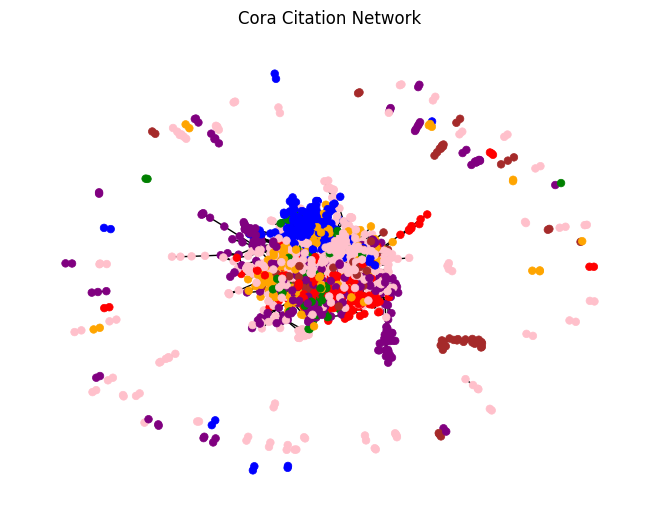

In [3]:
dataset = Cora()
set_seed(42)
X = dataset['features'].to(device)
labels = dataset['labels'].to(device)
G = Graph(dataset['num_vertices'], dataset['edge_list']).to(device)

def to_graph(cora_data):
    G = nx.Graph()
    G.add_nodes_from(range(cora_data['num_vertices']))
    G.add_edges_from(cora_data['edge_list'])
    return G

def visualize(cora_data):
    G = to_graph(cora_data)
    node_colors = ['red', 'green', 'blue', 'pink', 'purple', 'orange', 'brown']
    node_color = [node_colors[label] for label in cora_data['labels']]

    nx.draw(G, with_labels=False, node_color=node_color, edge_color='black', node_size=30, linewidths=0.5)
    plt.title("Cora Citation Network")

print("Drawing...")
visualize(dataset)

In [5]:
# Print the data object
print("Data object:", dataset)

# Print the number of classes
num_classes = dataset['num_classes']
print("Number of classes:", num_classes)

# Print the number of nodes
num_nodes = dataset['num_vertices']
print("Number of nodes:", num_nodes)

# Print the number of node features
num_node_features = dataset['dim_features']
print("Number of node features:", num_node_features)

# Print the edge index
print("Edge index:", dataset['edge_list'])

# Print the node features
print("Node features:", dataset['features'])

# Print the labels
print("Labels:", dataset['labels'])

# Print the train, validation, and test masks
train_mask = dataset['train_mask'].to(device)
val_mask = dataset['val_mask'].to(device)
test_mask = dataset['test_mask'].to(device)
print("Train mask:", train_mask)
print("Validation mask:", val_mask)
print("Test mask:", test_mask)


Data object: This is cora dataset:
  ->  num_classes
  ->  num_vertices
  ->  num_edges
  ->  dim_features
  ->  features
  ->  edge_list
  ->  labels
  ->  train_mask
  ->  val_mask
  ->  test_mask
Please try `data['name']` to get the specified data.
Number of classes: 7
Number of nodes: 2708
Number of node features: 1433
Edge index: [(0, 633), (0, 1862), (0, 2582), (1, 2), (1, 652), (1, 654), (2, 1986), (2, 332), (2, 1666), (2, 1), (2, 1454), (3, 2544), (4, 2176), (4, 1016), (4, 2176), (4, 1761), (4, 1256), (4, 2175), (5, 1629), (5, 2546), (5, 1659), (5, 1659), (6, 1416), (6, 1602), (6, 1042), (6, 373), (7, 208), (8, 281), (8, 1996), (8, 269), (9, 2614), (9, 723), (9, 723), (10, 476), (10, 2545), (11, 1655), (11, 1839), (12, 2661), (12, 1001), (12, 1318), (12, 2662), (13, 1810), (13, 1701), (14, 2034), (14, 2075), (14, 158), (14, 2077), (14, 2668), (15, 2367), (15, 1093), (15, 1090), (15, 1271), (15, 1093), (16, 2444), (16, 1632), (16, 970), (16, 2642), (17, 24), (17, 2140), (17, 131

In [6]:
print(G.deg_v)

[3.0, 3.0, 5.0, 1.0, 5.0, 3.0, 4.0, 1.0, 3.0, 2.0, 2.0, 2.0, 4.0, 2.0, 5.0, 4.0, 4.0, 5.0, 5.0, 1.0, 5.0, 2.0, 5.0, 1.0, 7.0, 4.0, 5.0, 4.0, 1.0, 2.0, 6.0, 1.0, 4.0, 9.0, 1.0, 3.0, 8.0, 3.0, 4.0, 7.0, 3.0, 4.0, 2.0, 6.0, 3.0, 6.0, 2.0, 2.0, 9.0, 2.0, 1.0, 6.0, 5.0, 3.0, 2.0, 12.0, 4.0, 1.0, 1.0, 10.0, 3.0, 5.0, 1.0, 1.0, 3.0, 10.0, 1.0, 3.0, 3.0, 7.0, 2.0, 3.0, 2.0, 12.0, 9.0, 6.0, 3.0, 2.0, 3.0, 2.0, 3.0, 4.0, 2.0, 2.0, 5.0, 3.0, 4.0, 3.0, 36.0, 10.0, 4.0, 6.0, 2.0, 4.0, 11.0, 21.0, 1.0, 2.0, 1.0, 6.0, 2.0, 3.0, 8.0, 6.0, 4.0, 4.0, 1.0, 4.0, 3.0, 32.0, 5.0, 6.0, 4.0, 3.0, 3.0, 1.0, 2.0, 2.0, 19.0, 6.0, 5.0, 7.0, 4.0, 4.0, 5.0, 2.0, 6.0, 1.0, 4.0, 2.0, 3.0, 2.0, 5.0, 9.0, 1.0, 3.0, 1.0, 4.0, 3.0, 8.0, 2.0, 3.0, 5.0, 3.0, 4.0, 6.0, 5.0, 2.0, 5.0, 4.0, 3.0, 4.0, 4.0, 6.0, 12.0, 7.0, 6.0, 4.0, 4.0, 2.0, 7.0, 2.0, 5.0, 1.0, 2.0, 4.0, 2.0, 4.0, 3.0, 2.0, 2.0, 3.0, 5.0, 4.0, 4.0, 7.0, 3.0, 4.0, 1.0, 3.0, 10.0, 4.0, 2.0, 3.0, 1.0, 2.0, 6.0, 1.0, 2.0, 4.0, 2.0, 6.0, 1.0, 2.0, 5.0, 2.0, 3.0, 3.

# Models

## MPNN

In [97]:
class MPNN(nn.Module):
    def __init__(self, num_features: int, G: Graph):
        super().__init__()
        self.width = num_features
        self.G = G
        self.lin_message = nn.Linear(num_features, num_features, 
                                     bias=False)
        self.lin_update = nn.Linear(num_features, num_features, 
                                    bias=True)
        
    def random_walk_matrix(self):
        in_deg = self.G.deg_v
        edge_weight = torch.zeros(self.G.num_e, dtype=torch.float32)
        for i, e in enumerate(self.G.e[0]):
            edge_weight[i] = 1.0 / in_deg[e[1]]
        return edge_weight

    def forward(self, x, edge_weight=None):
        if edge_weight is None:
            edge_weight = self.random_walk_matrix()
            edge_weight = torch.cat([edge_weight, edge_weight], dim=0)
        m_ji = self.lin_message(x)
        m_i = self.G.v2v(m_ji, "mean", edge_weight)
        h_i = torch.nn.GELU()(self.lin_update(x) + m_i)
        return h_i
    
class MPNNClassifier(nn.Module):
    def __init__(self, num_features: int, num_classes: int, G: Graph, num_iterations: int):
        super().__init__()
        self.classifier = nn.Linear(num_features, num_classes)
        self.G = G
        self.num_iterations = num_iterations
        self.mpnn = MPNN(num_features, G)

    def forward(self, x, edge_weight=None):
        # Pass the input through the MPNN for a number of iterations
        for i in range(self.num_iterations):
            x = self.mpnn(x, edge_weight)
        # Pass the output through the classifier
        out = self.classifier(x)
        # Apply softmax to get probabilities
        out = F.softmax(out, dim=1)
        return out

## CoGNN

In [109]:
def random_walk_matrix(G):
    in_deg = G.deg_v
    edge_weight = torch.zeros(G.num_e, dtype=torch.float32)
    for i, e in enumerate(G.e[0]):
        edge_weight[i] = 1.0 / in_deg[e[1]]
    return edge_weight

class action_net(torch.nn.Module):
    """Classify a node feature vector into {S,L,B,I}."""
    def __init__(self, num_features: int, G: Graph):
        super().__init__()
        self.lin_message = torch.nn.Linear(num_features, 4)
        self.lin_update = nn.Linear(num_features, 4, bias=True)
        self.G = G
    
    def forward(self, x, edge_weight=None):
        if edge_weight is None:
            edge_weight = random_walk_matrix(self.G)
            edge_weight = torch.cat([edge_weight, edge_weight], dim=0)
        m_ji = self.lin_message(x)
        m_i = self.G.v2v(m_ji, "mean", edge_weight)
        h_i = torch.nn.GELU()(self.lin_update(x) + m_i)
        h_i = F.log_softmax(h_i, dim=1)
        return h_i
    
class CoGNN(nn.Module):
    def __init__(self, num_features: int, G: Graph):
        super().__init__()
        self.G = G
        self.lin_message = nn.Linear(num_features, num_features, bias=False)
        self.lin_update = nn.Linear(num_features, num_features, bias=True)
        self.action_net = action_net(num_features, G)

    def forward(self, x, edge_weight=None):
        if edge_weight is None:
            edge_weight = random_walk_matrix(self.G)
            edge_weight = torch.cat([edge_weight, edge_weight], dim=0)

        # Determine the actions
        p_i = self.action_net(x) # probabilities for action selection {S, L, B, I}
        # Sample an action using the straight-through Gumbel-softmax estimator
        action = F.gumbel_softmax(p_i, hard=True)
        # Unless the action is S or B, the sent message is zero
        send = action[:, 0] + action[:, 2]
        # Unless the action is S or L, the received message is zero
        receive = action[:, 0] + action[:, 1]
        
        # Compute the messages
        m_ji = self.lin_message(x)
        m_ji = m_ji * send.view(-1, 1) # mask the messages

        # Aggregate the messages
        m_i = self.G.v2v(m_ji, "mean", edge_weight)
        m_i = m_i * receive.view(-1, 1) # mask the messages

        h_i = torch.nn.GELU()(self.lin_update(x) + m_i)
        return h_i
    
class CoGNNClassifier(nn.Module):
    def __init__(self, num_features: int, num_classes: int, G: Graph, num_iterations: int):
        super().__init__()
        self.classifier = nn.Linear(num_features, num_classes)
        self.G = G
        self.num_iterations = num_iterations
        self.mpnn = CoGNN(num_features, G)

    def forward(self, x, edge_weight=None):
        # Pass the input through the MPNN for a number of iterations
        for i in range(self.num_iterations):
            x = self.mpnn(x, edge_weight)
        # Pass the output through the classifier
        out = self.classifier(x)
        # Apply softmax to get probabilities
        out = F.softmax(out, dim=1)
        return out

# Training

In [122]:
# Initialize the model
model = CoGNNClassifier(num_node_features, num_classes, G, 2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

model.to(device)

print("Model:", model)
print("Optimizer:", optimizer)
print("Model Device:", next(model.parameters()).device)
print("Data Device:", X.device)

Model: CoGNNClassifier(
  (classifier): Linear(in_features=1433, out_features=7, bias=True)
  (mpnn): CoGNN(
    (lin_message): Linear(in_features=1433, out_features=1433, bias=False)
    (lin_update): Linear(in_features=1433, out_features=1433, bias=True)
    (action_net): action_net(
      (lin_message): Linear(in_features=1433, out_features=4, bias=True)
      (lin_update): Linear(in_features=1433, out_features=4, bias=True)
    )
  )
)
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
Model Device: cuda:0
Data Device: cuda:0


In [123]:
# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(X)
    loss = F.nll_loss(out[train_mask], labels[train_mask])
    #loss = F.cross_entropy(out[train_mask], labels[train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def validate():
    model.eval()
    with torch.no_grad():
        logits = model(X) # Log probabilities

        # Train accuracy
        train_logits = logits[train_mask] # Log probabilities of train nodes
        train_labels = labels[train_mask] # True labels of train nodes
        train_pred = train_logits.max(1)[1] # Predicted labels
        train_correct = train_pred.eq(train_labels).sum().item() # Number of correctly classified nodes
        train_accuracy = train_correct / train_mask.sum().item() # Accuracy

        # Validation accuracy
        val_logits = logits[val_mask] # Log probabilities of validation nodes
        val_labels = labels[val_mask] # True labels of validation nodes
        val_pred = val_logits.max(1)[1] # Predicted labels
        val_correct = val_pred.eq(val_labels).sum().item() # Number of correctly classified nodes
        val_accuracy = val_correct / val_mask.sum().item() # Accuracy
            
    return train_accuracy, val_accuracy

# Testing function
def test():
    model.eval()
    with torch.no_grad():
        logits = model(X) # Log probabilities
        test_logits = logits[test_mask] # Log probabilities of test nodes
        test_labels = labels[test_mask] # True labels of test nodes
        pred = test_logits.max(1)[1] # Predicted labels
        correct = pred.eq(test_labels).sum().item() # Number of correctly classified nodes
        accuracy = correct / test_mask.sum().item() # Accuracy
    return accuracy, pred

from sklearn.metrics import confusion_matrix

def visualize_results():
    model.eval()
    with torch.no_grad():
        logits = model(X) # Log probabilities
        test_logits = logits[test_mask] # Log probabilities of test nodes
        test_labels = labels[test_mask] # True labels of test nodes
        pred = test_logits.max(1)[1] # Predicted labels

        # Draw the graph with different colors for each class
        node_color = []
        # set the color of the nodes based on whether the prediction is correct
        j = 0
        for i in range(len(labels)):
            if test_mask[i]:
                if pred[j] == labels[i]:
                    node_color.append("green")
                else:
                    node_color.append("red")
                j += 1
            else:
                node_color.append("gray")

        cm = confusion_matrix(test_labels.cpu(), pred.cpu())

        # Normalize confusion matrix
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        fig, ax = plt.subplots(1, 2, figsize=(20,10))

        # Plot confusion matrix
        im = ax[0].matshow(cm, cmap=plt.cm.Blues)
        plt.colorbar(im, ax=ax[0])
        ax[0].set_title('Confusion matrix')
        ax[0].set_ylabel('True label')
        ax[0].set_xlabel('Predicted label')

        # Plot the graph
        nx.draw(to_graph(dataset), ax=ax[1], with_labels=False, node_color=node_color, edge_color='black', node_size=50, linewidths=0.5, font_size=8)
        ax[1].set_title("Prediction result")
        plt.show()

In [124]:
# Run the training
for epoch in range(1000):
    loss = train()

    if epoch % 50 == 0:
        train_accuracy, val_accuracy = validate()
        print(f'Epoch {epoch+1}, Loss: {loss:.4f}')
        print(f'Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Epoch 1, Loss: -0.1428
Training Accuracy: 0.1643, Validation Accuracy: 0.1180
Epoch 51, Loss: -0.1536
Training Accuracy: 0.3929, Validation Accuracy: 0.2120
Epoch 101, Loss: -0.1779
Training Accuracy: 0.3857, Validation Accuracy: 0.2340
Epoch 151, Loss: -0.3784
Training Accuracy: 0.4643, Validation Accuracy: 0.2720
Epoch 201, Loss: -0.6004
Training Accuracy: 0.8071, Validation Accuracy: 0.3840
Epoch 251, Loss: -0.7864
Training Accuracy: 0.8429, Validation Accuracy: 0.4160
Epoch 301, Loss: -0.9045
Training Accuracy: 0.9786, Validation Accuracy: 0.5920
Epoch 351, Loss: -0.9633
Training Accuracy: 0.9929, Validation Accuracy: 0.5740
Epoch 401, Loss: -0.9812
Training Accuracy: 0.9929, Validation Accuracy: 0.5860
Epoch 451, Loss: -0.9857
Training Accuracy: 0.9929, Validation Accuracy: 0.5720
Epoch 501, Loss: -0.9886
Training Accuracy: 0.9929, Validation Accuracy: 0.5820
Epoch 551, Loss: -0.9858
Training Accuracy: 0.9929, Validation Accuracy: 0.5880
Epoch 601, Loss: -0.9907
Training Accuracy:

Test Accuracy: 0.5980, Training Accuracy: 0.9929, Validation Accuracy: 0.6100


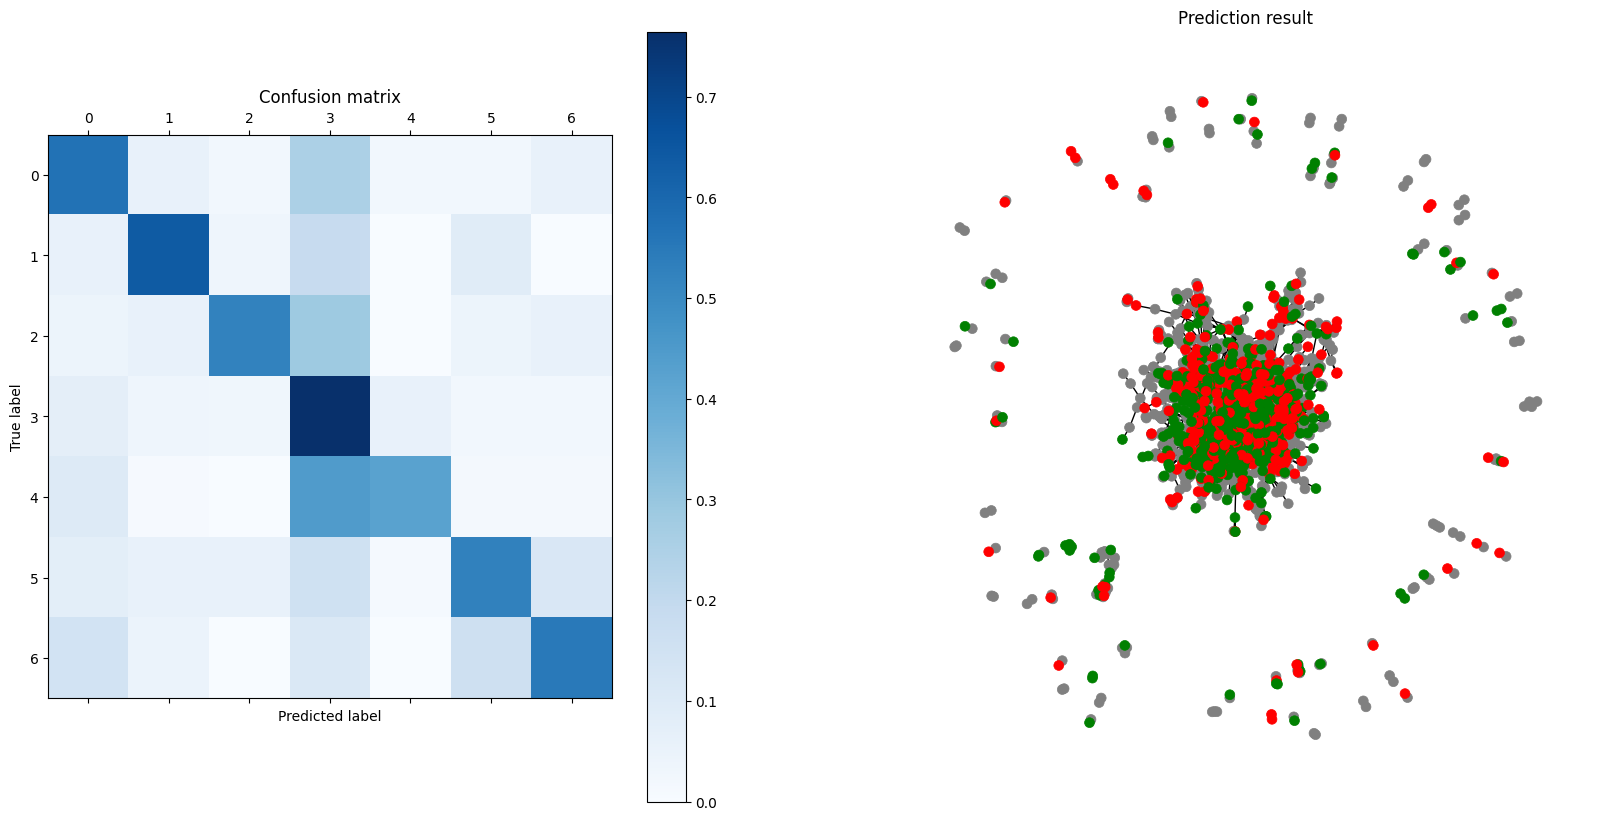

In [125]:
# Test the model
train_accuracy, val_accuracy = validate()
accuracy, predictions = test()
print(f'Test Accuracy: {accuracy:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')

visualize_results()